In [1]:
import random
import os

from transformers import (
    MaskFormerConfig,
    MaskFormerImageProcessor,
    MaskFormerModel,
    MaskFormerForInstanceSegmentation
)

from huggingface_hub import notebook_login
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from datasets import load_dataset
import matplotlib.pyplot as plt
import albumentations as A
from tqdm import tqdm
from torch import nn
import pandas as pd
import numpy as np
import evaluate
import torch


/opt/conda/envs/tensor/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ROOT_PATH = '/'.join(os.getcwd().split('/')[:-2])
DATA_PATH = f'{ROOT_PATH}/dataset/placeschallenge'

In [3]:
train = load_dataset('scene_parse_150', 'instance_segmentation', split = 'train')
valid = load_dataset('scene_parse_150', 'instance_segmentation', split = 'validation')
test  = load_dataset('scene_parse_150', 'instance_segmentation', split = 'test')

Found cached dataset scene_parse_150 (/home/jovyan/.cache/huggingface/datasets/scene_parse_150/instance_segmentation/1.0.0/d998c54e1b5c5bad12b4d2ec7e1a5f74eee4c153bc1b089a0001677ae9b3fd75)
Found cached dataset scene_parse_150 (/home/jovyan/.cache/huggingface/datasets/scene_parse_150/instance_segmentation/1.0.0/d998c54e1b5c5bad12b4d2ec7e1a5f74eee4c153bc1b089a0001677ae9b3fd75)
Found cached dataset scene_parse_150 (/home/jovyan/.cache/huggingface/datasets/scene_parse_150/instance_segmentation/1.0.0/d998c54e1b5c5bad12b4d2ec7e1a5f74eee4c153bc1b089a0001677ae9b3fd75)


In [4]:
print(train[0])

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7FB5EDC21CD0>, 'annotation': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256 at 0x7FB5BA496700>}


In [5]:
idx        = random.randint(0, len(train))
image      = np.array(train[idx]['image'].convert('RGB'))
annotation = np.array(train[idx]['annotation'])

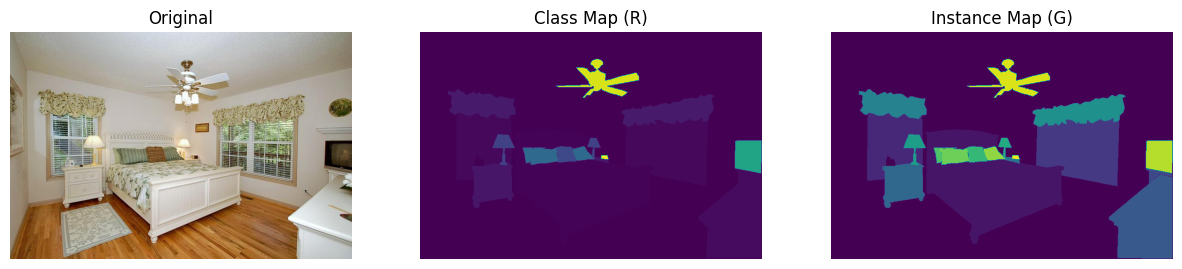

In [6]:
plt.figure(figsize = (15, 5))
for plot_index in range(3):
    
    if plot_index == 0:
        plot_image = image
        title = 'Original'
        
    else:
        plot_image = annotation[..., plot_index - 1]
        title     = ['Class Map (R)', 'Instance Map (G)'][plot_index - 1]
        
    
    plt.subplot(1, 3, plot_index + 1)
    plt.imshow(plot_image)
    plt.title(title)
    plt.axis('off')

In [7]:
processor = MaskFormerImageProcessor(
    reduce_labels = True,
    size          = (512, 512),
    ignore_index  = 255,
    do_resize     = False,
    do_rescale    = False,
    do_normalize  = False
)

/opt/conda/envs/tensor/lib/python3.8/site-packages/transformers/models/maskformer/image_processing_maskformer.py:421: FutureWarning: The `reduce_labels` argument is deprecated and will be removed in v4.27. Please use `do_reduce_labels` instead.
  warnings.warn(


In [8]:
model_name = 'facebook/maskformer-swin-base-ade'
config     = MaskFormerConfig.from_pretrained(model_name)

In [9]:
data = pd.read_csv(
    f'{DATA_PATH}/instanceInfo100_train.txt', sep = '\t',
    header = 0, on_bad_lines = 'skip'
)

idx2lb = {idx : lb.strip() for idx, lb in enumerate(data['Object Names'])}
lb2idx = {v : k for k, v in idx2lb.items()}

config.idx2lb = idx2lb
config.lb2idx = lb2idx

In [10]:
model      = MaskFormerForInstanceSegmentation(config)
base_model = MaskFormerModel.from_pretrained(model_name)
model.mode = base_model

Some weights of the model checkpoint at facebook/maskformer-swin-base-ade were not used when initializing MaskFormerModel: ['mask_embedder.2.0.weight', 'mask_embedder.2.0.bias', 'mask_embedder.0.0.bias', 'mask_embedder.1.0.bias', 'mask_embedder.0.0.weight', 'criterion.empty_weight', 'mask_embedder.1.0.weight', 'class_predictor.bias', 'class_predictor.weight']
- This IS expected if you are initializing MaskFormerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MaskFormerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD  = np.array([58.395, 57.120, 57.375]) / 255

In [12]:
train_val_transform = A.Compose([
    A.Resize(width = 512, height = 512),
    A.HorizontalFlip(p = 0.3),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD)
])

In [13]:
class ImageSegmentationDataset(Dataset):
    
    def __init__(self, dataset, processor, transform = None):
        
        self.dataset   = dataset
        self.processor = processor
        self.transform = transform
        
    
    def __len__(self): return len(self.dataset)


    def __getitem__(self, idx):
        
        image = np.array(self.dataset[idx]['image'].convert('RGB'))
        
        instance_seg = np.array(self.dataset[idx]['annotation'])[..., 1]
        class_id_map = np.array(self.dataset[idx]['annotation'])[..., 0]
        
        class_labels = np.unique(class_id_map)
        instance2class = {}
        for lb in class_labels:
            instance_ids = np.unique(instance_seg[class_id_map == lb])
            instance2class.update({i : lb for i in instance_ids})
            
        if self.transform is not None:
            
            transformed           = self.transform(image = image, mask = instance_seg)
            (image, instance_seg) = (transformed['image'], transformed['mask'])
            
            image = image.transpose(2, 0, 1)
            
        
        conditions = [class_labels.shape[0] == 1, class_labels[0] == 0]
        if all(conditions):
            
            inputs = self.processor([image], return_tensors = 'pt')
            inputs = {k : v.squeeze() for k, v in inputs.items()}
            
            inputs['class_labels'] = torch.tensor([0])
            inputs['mask_labels']  = torch.zeros(
                                    (0, inputs['pixel_values'].shape[-2], inputs['pixel_values'].shape[-1])
                                )
        else:
            inputs = self.processor(
                        [image], [instance_seg],
                        instance_id_to_semantic_id = instance2class,
                        return_tensors = 'pt'
                    )
            
            inputs = {k : v.squeeze() if isinstance(v, torch.Tensor)
                                      else v[0] for k, v in inputs.items()}
        
        return inputs

In [14]:
train_dataset = ImageSegmentationDataset(train, processor = processor,
                                        transform = train_val_transform)

valid_dataset = ImageSegmentationDataset(valid, processor = processor,
                                        transform = train_val_transform)

In [15]:
inputs  = dict(sorted(valid_dataset[0].items(), key = lambda x: len(x[0])))
max_len = max([len(k) for k in inputs.keys()])

for k, v in inputs.items(): 
    print(f'{k} {" "*(max_len - len(k))}shape : {v.shape}')

pixel_mask   shape : torch.Size([512, 512])
mask_labels  shape : torch.Size([4, 512, 512])
pixel_values shape : torch.Size([3, 512, 512])
class_labels shape : torch.Size([4])


In [16]:
def collate_fn(samples):
    
    pixel_values = torch.stack([sample['pixel_values'] for sample in samples])
    pixel_mask   = torch.stack([sample['pixel_mask']   for sample in samples])
    
    mask_labels  = [sample['mask_labels'] for sample in samples]
    class_labels = [sample['class_labels'] for sample in samples]
    
    return {
        'pixel_values' : pixel_values,
        'pixel_mask'   : pixel_mask,
        'mask_labels'  : mask_labels,
        'class_labels' : class_labels
        
    }
                           
                           

train_loader = DataLoader(
    train_dataset, batch_size = 4,
    shuffle = True, collate_fn = collate_fn
)

valid_loader = DataLoader(
    valid_dataset, batch_size = 4,
    shuffle = False, collate_fn = collate_fn
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


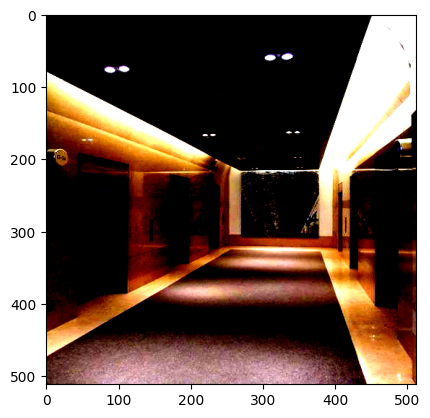

In [17]:
sample = next(iter(train_loader))
sample = np.transpose(sample['pixel_values'][0].squeeze(), (1, 2, 0))

plt.imshow(sample)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer  = torch.optim.Adam(model.parameters(), lr = 5e-5)
num_epochs = 2

for epoch in range(1, num_epochs + 1):
    
    print(f'[{epoch} / {num_epochs}] Training')
    model.train()
    
    train_loss, valid_loss = [], []
    for idx, batch in enumerate(tqdm(train_loader)):
        
        optimizer.zero_grad()
        outputs = model(
            pixel_values = batch['pixel_values'].to(device),
            mask_labels  = [labels.to(device) for labels in batch['mask_labels']],
            class_labels = [labels.to(device) for labels in batch['class_labels']]
        )
        
        loss = outputs.loss
        train_loss.append(loss.item())
        loss.backward()
        
        if idx % 1000 == 0:
            print(f'[{epoch} / {num_epochs}] training loss : {round(sum(train_loss)/ len(train_loss), 3)}')
        
        
        optimizer.step()
        
    train_loss = sum(train_loss) / len(train_loss)
    model.eval()
    
    start_idx = 0
    print(f'[{epoch} / {num_epochs}] Validation')
    
    for idx, batch in enumerate(tqdm(valid_loader)):
        
        with torch.no_grad():
            outputs = model(
                pixel_values = batch['pixel_values'].to(device),
                mask_labels  = [labels.to(device) for labels in batch['mask_labels']],
                class_labels = [labels.to(device) for labels in batch['class_labels']]
                
            )
            
            loss = outputs.loss
            valid_loss.append(loss.item())
            
            if idx % 1000 == 0:
                print(f'[{epoch} / {num_epochs}] validation loss : {round(sum(valid_loss)/ len(valid_loss), 3)}')
            
    valid_loss = sum(valid_loss) / len(valid_loss)
    
    print(f'[{epoch} / {num_epochs}] train loss : {train_loss} | valid loss : {valid_loss}')

[1 / 2] Training


  0%|          | 1/5053 [00:02<4:03:25,  2.89s/it]

[1 / 2] training loss : 9.619


 20%|█▉        | 1001/5053 [12:58<1:04:54,  1.04it/s]

[1 / 2] training loss : 3.845


 40%|███▉      | 2001/5053 [26:40<44:39,  1.14it/s]  

[1 / 2] training loss : 3.727


 59%|█████▉    | 3001/5053 [40:27<32:50,  1.04it/s]

[1 / 2] training loss : 3.647


 79%|███████▉  | 4001/5053 [51:17<08:45,  2.00it/s]

[1 / 2] training loss : 3.611


 99%|█████████▉| 5001/5053 [59:48<00:26,  1.97it/s]

[1 / 2] training loss : 3.573


100%|██████████| 5053/5053 [1:00:14<00:00,  1.40it/s]


[1 / 2] Validation


  0%|          | 1/500 [00:00<02:48,  2.96it/s]

[1 / 2] validation loss : 4.756


100%|██████████| 500/500 [02:29<00:00,  3.34it/s]


[1 / 2] train loss : 3.5719823504931 | valid loss : 4.374768330335617
[2 / 2] Training


  0%|          | 1/5053 [00:00<48:50,  1.72it/s]

[2 / 2] training loss : 4.297


 20%|█▉        | 1001/5053 [08:32<34:30,  1.96it/s]

[2 / 2] training loss : 3.402


 35%|███▍      | 1756/5053 [14:58<29:00,  1.89it/s]